## Анализ продаж сервиса Яндекс Афиша #

- Дата : 06.06.2025
- Автор проекта : Садовников Андрей Андреевич

### Цели и задачи
#### Анализ сезонности

- Определить, как изменился спрос на мероприятия в осенний период (сентябрь–октябрь 2024) по сравнению с летним.

- Выявить наиболее востребованные категории событий и их динамику.

#### Изучение аудитории

Сравнить активность пользователей мобильных и стационарных устройств:

- Среднее количество заказов на пользователя.

- Время между заказами.

- Средний чек.

- Проверить, изменилась ли структура аудитории (например, приток новых пользователей).

#### Анализ мероприятий и партнёров

- Определить топ-5 самых популярных типов мероприятий осенью 2024.

Выявить лидеров среди организаторов и площадок по:

- Количеству заказов.

- Выручке.

- Уникальным мероприятиям.

- Сравнить их показатели с летним периодом.

Проанализировать активность по регионам:

- Где наблюдается рост/падение спроса?

- Какие регионы генерируют наибольшую выручку?

В наешм распоряжении будут данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. 

- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных;
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.

Второй датасет final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 

- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

Датасет final_tickets_tenge_df.csv содержит информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:

- nominal — номинал (100 тенге);
- data — дата;
- curs — курс тенге к рублю;
- cdx — обозначение валюты (kzt).

### Знакомство с данными

In [1]:
# Импортируем необходимые библиотеки дя выпорнения проекта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
from scipy import stats

In [2]:
# Загрузим первый датасет с информацие о заказах
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')

In [3]:
# Посмотрим информацию о сохраненном датасете
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [4]:
# Перобразуем колонки с датами к соответствующему типу данных
final_tickets_orders_df['created_dt_msk'] = pd.to_datetime(final_tickets_orders_df['created_dt_msk'])
final_tickets_orders_df['created_ts_msk'] = pd.to_datetime(final_tickets_orders_df['created_ts_msk'])

In [5]:
# Оптимизируем тип данных в колонке с возростными ограничениями
final_tickets_orders_df['age_limit'] = final_tickets_orders_df['age_limit'].astype('int8')

In [6]:
# Проверим корректность типов даных
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int8          
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [7]:
# Проверим первые 5 строк
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [8]:
# Загрузим второй датасет с информацией о событиях и посмотрим информацию о нем
final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')

In [9]:
# Посмотрим информацию о сохраненном датасете
final_tickets_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [10]:
# Посмотрим первые 5 строк
final_tickets_events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [11]:
# Загрузим последний датасет с информацией о курсе валют
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
# Посмотрим информацию о сохраненном датасете
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [13]:
# Посмотрим ее содержание
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
# Преобразуем дату к соответствующему типу
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

#### Промежуточные выводы 
По итогу выгрузки и знакомства с данными можно выделить:
- Отсутствие пропусков
- Испльзование не оптимального типа данных
- В датасете final_tickets_orders_df дублируется дата в 2х колонка, created_dt_msk и created_ts_msk

### Проверка категорийных значений

#### Проверим категорийные значения датасета final_tickets_orders_df

In [15]:
set(final_tickets_orders_df['currency_code'])

{'kzt', 'rub'}

In [16]:
set(final_tickets_orders_df['age_limit'])

{0, 6, 12, 16, 18}

In [17]:
set(final_tickets_orders_df['device_type_canonical'])

{'desktop', 'mobile'}

In [18]:
set(final_tickets_orders_df['service_name'])

{'Crazy ticket!',
 'Show_ticket',
 'Билет по телефону',
 'Билеты без проблем',
 'Билеты в интернете',
 'Билеты в руки',
 'Быстробилет',
 'Быстрый кассир',
 'Весь в билетах',
 'Восьмёрка',
 'Вперёд!',
 'Выступления.ру',
 'Городской дом культуры',
 'Дом культуры',
 'Дырокол',
 'За билетом!',
 'Зе Бест!',
 'КарандашРУ',
 'Кино билет',
 'Край билетов',
 'Лимоны',
 'Лови билет!',
 'Лучшие билеты',
 'Мир касс',
 'Мой билет',
 'Облачко',
 'Прачечная',
 'Радио ticket',
 'Реестр',
 'Росбилет',
 'Тебе билет!',
 'Телебилет',
 'Тех билет',
 'Цвет и билет',
 'Шоу начинается!',
 'Яблоко'}

В датасете final_tickets_orders_df не выявлено дубликатов или ошибочных значений

#### Проверим категорийные значения датасета final_tickets_events_df

In [19]:
set(final_tickets_events_df['event_type_description'])

{'балет',
 'выставка',
 'концерт',
 'кукольный спектакль',
 'музыкальный спектакль',
 'мюзикл',
 'опера',
 'оперетта',
 'подарок',
 'рок-мюзикл',
 'снегурочка',
 'событие',
 'спектакль',
 'спорт',
 'спортивное мероприятие',
 'фестиваль',
 'цирковое шоу',
 'шоу',
 'экскурсия',
 'ёлка'}

In [20]:
set(final_tickets_events_df['event_type_main'])

{'выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр', 'ёлки'}

В датасете final_tickets_events_df не выявлено дубликатов или ошибочных значений

#### Проверим категорийные значения датасетоа final_tickets_tenge_df

In [21]:
set(final_tickets_tenge_df['cdx'])

{'kzt'}

В датасете final_tickets_tenge_df не выявлено дубликатов или ошибочных значений

#### Промежуточнй вывод
В представленных датасетах не было выявлено неявных дубликатов в категорийных значениях

### Проверим количественные значения выручки в разрезе валют

In [22]:
# Разделим датасет на 2 по типу валют
df_rub = final_tickets_orders_df[final_tickets_orders_df['currency_code'] == 'rub'].copy()
df_kzt = final_tickets_orders_df[final_tickets_orders_df['currency_code'] == 'kzt'].copy()

In [23]:
# Проверим показатели получившихся датасетов
print("Выручка (RUB):\n", df_rub['revenue'].describe())
print("\nВыручка (KZT):\n", df_kzt['revenue'].describe())

Выручка (RUB):
 count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

Выручка (KZT):
 count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


В таблице с рублевой выручкой обнаружены орицательные значения, что скорее всего ошибка.

Построим гистограммы для анализа распределения

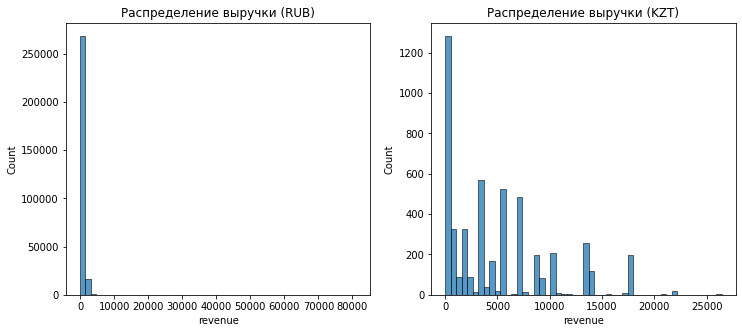

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_rub['revenue'], bins=50)
plt.title('Распределение выручки (RUB)')

plt.subplot(1, 2, 2)
sns.histplot(df_kzt['revenue'], bins=50)
plt.title('Распределение выручки (KZT)')
plt.show()

На графике видно, что в рублевом сегмете, вся основная часть выручки сконцентрирована в заказах до 3 000р.
Распределение выручки в KZT имеет нормально распределение, мез аномальных знгачений.

Построим boxplot для выявления выбросов

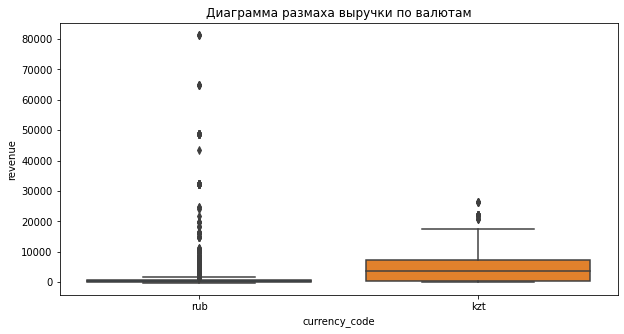

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=final_tickets_orders_df, x='currency_code', y='revenue')
plt.title('Диаграмма размаха выручки по валютам')
plt.show()

Для дальнейшей работы, очистим данные с рублевой выручки от выбросов исключив из датасета значения выше 99-го процентиля.

In [26]:
high_values_revenue_rub = final_tickets_orders_df[final_tickets_orders_df['currency_code'] =='rub']['revenue'].quantile(0.99)
df_rub_clean = final_tickets_orders_df[final_tickets_orders_df['revenue'] <= high_values_revenue_rub]

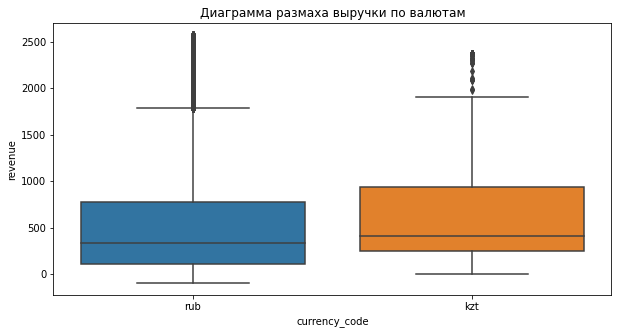

In [27]:
# Проверим результат очистки
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_rub_clean, x='currency_code', y='revenue')
plt.title('Диаграмма размаха выручки по валютам')
plt.show()

#### Промежуточные выводы
При ровереке количественных значений выручк были выявлены анамально высоки значения в рублевом сегменты, возможно это корпоративные заказы или дорогие VIP билеты.
Аномалий в KZT выялено не было

### Проверим количественные значения билетов в разрезе валют.
Проведем такой же анализ, как и для выручки.

In [28]:
#Проверим статистические показатели
print("Билеты (RUB):\n", df_rub['tickets_count'].describe())
print("\nБилеты (KZT):\n", df_kzt['tickets_count'].describe())

Билеты (RUB):
 count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Билеты (KZT):
 count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


Сразу можно обратить внимания количество билетов, за рубли заказов в несколько раз больше, чем за KZT.
Так же максимальное значение в 57, может говорить о наличии выбрасов

Построим гистограммы для анализа распределения

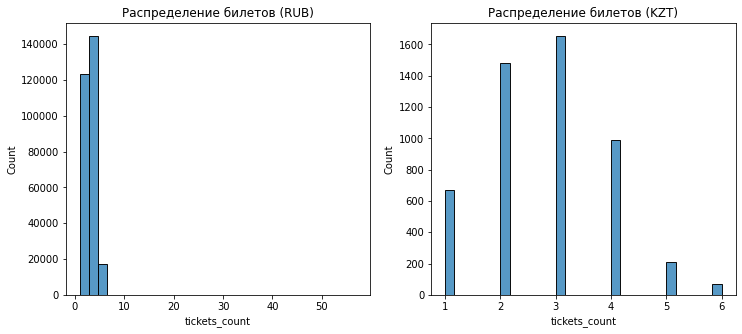

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_rub['tickets_count'], bins=30)
plt.title('Распределение билетов (RUB)')

plt.subplot(1, 2, 2)
sns.histplot(df_kzt['tickets_count'], bins=30)
plt.title('Распределение билетов (KZT)')
plt.show()

Основное количество билетов за рубли варьируется до 10шт в заказе.
Опять же билеты в заказе за KZT имеют нормальное распрееление с пиком в значении 3

Построим boxplot для выявление выбросов 

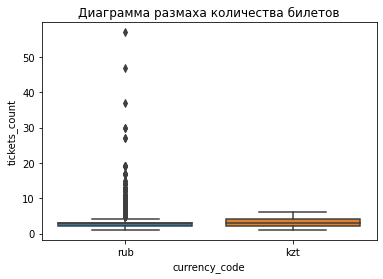

In [30]:
sns.boxplot(data=df_rub_clean, x='currency_code', y='tickets_count')
plt.title('Диаграмма размаха количества билетов')
plt.show()

Очистим данные от выбрасов аналогичным с выручкой способом.

In [31]:
high_values_ticket_rub = df_rub_clean[df_rub_clean['currency_code'] =='rub']['tickets_count'].quantile(0.99)
clean_final_tickets_orders_df = df_rub_clean[df_rub_clean['tickets_count'] <= high_values_ticket_rub]

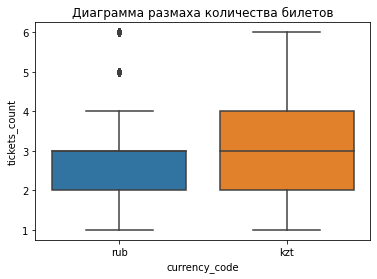

In [32]:
# Проверим выбросы после очистки
sns.boxplot(data=clean_final_tickets_orders_df, x='currency_code', y='tickets_count')
plt.title('Диаграмма размаха количества билетов')
plt.show()

In [33]:
# Проверим от какого количества заказов мы очистили датасет
print(len(final_tickets_orders_df['order_id']) - len(clean_final_tickets_orders_df['order_id']))

6007


#### Промежуточные выводы
В рублевых заказах было обнаружено около 6000 аномально высоких значений,
В заказах за KZT все придерживается нормального распределения без выбросов.

### Проверка на дубликаты
#### Явные дубликаты

In [34]:
print(f"Найдено {clean_final_tickets_orders_df.duplicated().sum()} явных дубликатов.")

Найдено 0 явных дубликатов.


#### Неявные дубликаты

In [35]:
# Проверка на одинаковые события от одного пользователя в одно время
semantic_duplicates = clean_final_tickets_orders_df.duplicated(
    subset=['user_id', 'event_id', 'created_ts_msk', 'tickets_count', 'total'],
    keep=False
)
print(f"Найдено {semantic_duplicates.sum()} неявных дубликатов")

Найдено 83 неявных дубликатов


In [36]:
# Удалим одинаковые события
clean_orders_df = clean_final_tickets_orders_df.drop_duplicates(
    subset=['user_id', 'event_id', 'created_ts_msk', 'tickets_count', 'total'],
    keep='first'
)

#### Промежуточные выводы
В датасете небыло выявлено явных дубликатов, однако были выявлены не явные дубликаты, от одного и того же пользователя в одно время выло приобретено одинаковое количество билетов, возможно системные ошибки при оформлении заказов.

### Объединение таблиц

Для дальнейшей работы объединим датасеты с курсом валют и событиями с очищеным от выбросов датосетом

In [37]:
merged_curs_orders_df = pd.merge(
    clean_orders_df,
    final_tickets_tenge_df,
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

In [38]:
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int8          
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [39]:
clean_final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284842 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               284842 non-null  int64         
 1   user_id                284842 non-null  object        
 2   created_dt_msk         284842 non-null  datetime64[ns]
 3   created_ts_msk         284842 non-null  datetime64[ns]
 4   event_id               284842 non-null  int64         
 5   cinema_circuit         284842 non-null  object        
 6   age_limit              284842 non-null  int8          
 7   currency_code          284842 non-null  object        
 8   device_type_canonical  284842 non-null  object        
 9   revenue                284842 non-null  float64       
 10  service_name           284842 non-null  object        
 11  tickets_count          284842 non-null  int64         
 12  total                  284842 non-null  floa

In [40]:
merged_df= pd.merge(
    merged_curs_orders_df,
    final_tickets_events_df,
    on = 'event_id',
    how='left'
)

In [41]:
# Проверим получившийся датасет
merged_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


### Добавление новых колонок
#### revenue_rub

Добавим колонку revenue_rub, в которой приведем все значения выручки к рублю используя колонку curs

In [42]:
merged_df['revenue_rub'] = np.where(
    merged_df['currency_code'] == 'kzt',
    (merged_df['revenue'] / 100 * merged_df['curs']).round(2),
    merged_df['revenue'])

Проверим корректность вычисленгий, выведем первые 5 строк и посмотрим значения в колонке revenue_rub

In [43]:
merged_df[merged_df['currency_code'] == 'kzt'].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub
73,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.10,...,событие,другое,№5088,Верхоречная область,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",98.50
91,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.18,...,событие,другое,№5088,Верхоречная область,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",65.73
98,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.77,...,событие,другое,№5088,Верхоречная область,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",61.15
515,2044327,01370a0e9c1a7d5,2024-09-05,2024-09-05 16:13:00,561747,нет,16,kzt,mobile,361.08,...,событие,другое,№4950,Шанырский регион,Синеводск,29463.0,3407.0,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",66.52
516,2044298,01370a0e9c1a7d5,2024-09-05,2024-09-05 16:15:58,561747,нет,16,kzt,mobile,361.08,...,событие,другое,№4950,Шанырский регион,Синеводск,29463.0,3407.0,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",66.52


#### one_ticket_revenue_rub

Добавим колонку one_ticket_revenue_rub с ценой одного билета 

In [44]:
merged_df['one_ticket_revenue_rub'] = round(merged_df['revenue_rub'] / merged_df['tickets_count'], 2)

#### month

Добавим в нам датасет колонку month с числовым значением месяца

In [45]:
merged_df['month'] = merged_df['created_dt_msk'].dt.month

#### season

Добавим колонку с сезонами

In [46]:
season_map = {
    1: 'зима', 2: 'зима', 3: 'весна',
    4: 'весна', 5: 'весна', 6: 'лето',
    7: 'лето', 8: 'лето', 9: 'осень',
    10: 'осень', 11: 'осень', 12: 'зима'
}
merged_df['season'] = merged_df['month'].map(season_map)

### Итоги подготовки данных

Проверим получившийся после обработки и добавления новых элементов датасет

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284799 entries, 0 to 284798
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                284799 non-null  int64         
 1   user_id                 284799 non-null  object        
 2   created_dt_msk          284799 non-null  datetime64[ns]
 3   created_ts_msk          284799 non-null  datetime64[ns]
 4   event_id                284799 non-null  int64         
 5   cinema_circuit          284799 non-null  object        
 6   age_limit               284799 non-null  int8          
 7   currency_code           284799 non-null  object        
 8   device_type_canonical   284799 non-null  object        
 9   revenue                 284799 non-null  float64       
 10  service_name            284799 non-null  object        
 11  tickets_count           284799 non-null  int64         
 12  total                   284799

Рассчитаем долю срезаных данных после обработки

In [48]:
print(f"При обработки данных {round(1 - merged_df['order_id'].count() / final_tickets_orders_df['order_id'].count(), 2) * 100} % было отсеяно")

При обработки данных 2.0 % было отсеяно


#### Промежуточные выводы
Данные были подгатовлены для дальнейшего анализа, для этого было проведено :
- Очиска данных от явных и не явных дубликатов
- Таблици были объеденены в один датасет
- Были добавлены новые сущности для проведения дальнейших анализов

### Анализ заказов

Для каждого месяца найдем количество заказов и визуализируем результаты. Проверим, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

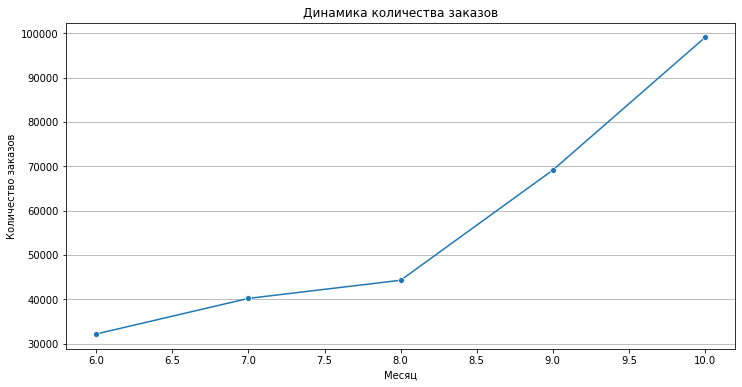

In [49]:
# Группировка по месяцам
month_orders = merged_df.groupby('month')['order_id'].count().reset_index()


# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data=month_orders, x='month', y='order_id', marker='o')
plt.title('Динамика количества заказов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.show()

#### Промежуточный вывод
Наблюдается значительный рост количества заказов к концу наблюдаемого периода.

### Анализ сезонности по количеству закаов

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

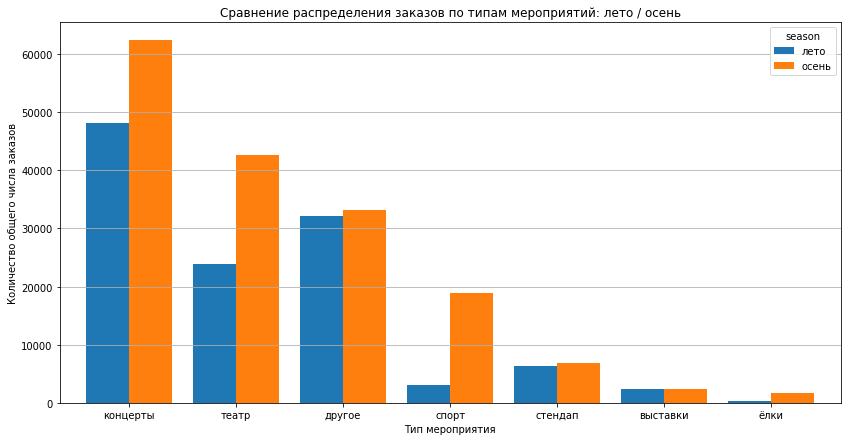

In [50]:
# Создадим таблицу для визуализации распределения заказов по типу мероприятия 
season_event_type = merged_df.pivot_table(
    index='event_type_main',
    columns='season',
    values='order_id',
    aggfunc='count',
    fill_value=0
)[['лето', 'осень']].sort_values('осень', ascending=False)

ax = season_event_type.plot(kind='bar', width=0.8, figsize=(14, 7))
plt.title('Сравнение распределения заказов по типам мероприятий: лето / осень')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество общего числа заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')

In [51]:
# Проверим, совпадает ли распределение количества заказов, с распределением количества событий по каждому типу событий
events_by_type = merged_df.groupby('event_type_main')['event_id'].nunique().reset_index().sort_values('event_id')
print(events_by_type)

  event_type_main  event_id
6            ёлки       214
0        выставки       289
4         стендап       632
3           спорт       865
1          другое      4650
5           театр      7066
2        концерты      8625


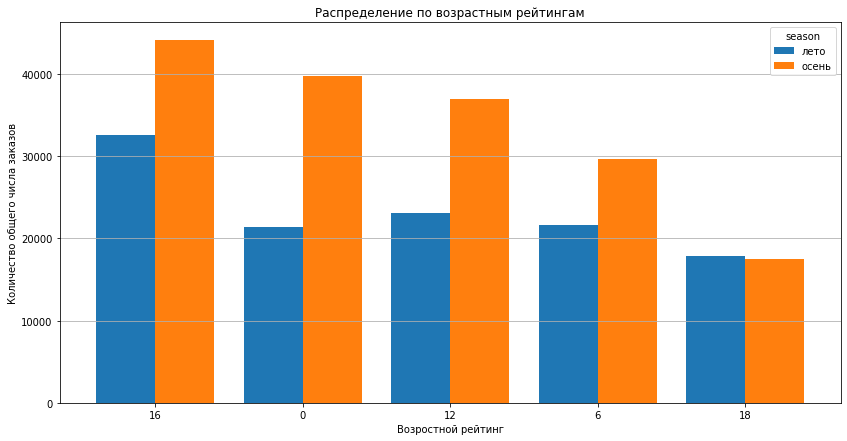

In [52]:
# Создадим таблицу для визуализации распределения заказов по возростному рейтингу
season_age_limit = merged_df.pivot_table(
    index='age_limit',
    columns='season',
    values='order_id',
    aggfunc='count',
    fill_value=0
)[['лето', 'осень']].sort_values('осень', ascending=False)

ax = season_age_limit.plot(kind='bar', width=0.8, figsize=(14, 7))
plt.title('Распределение по возрастным рейтингам')
plt.xlabel('Возростной рейтинг')
plt.ylabel('Количество общего числа заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')

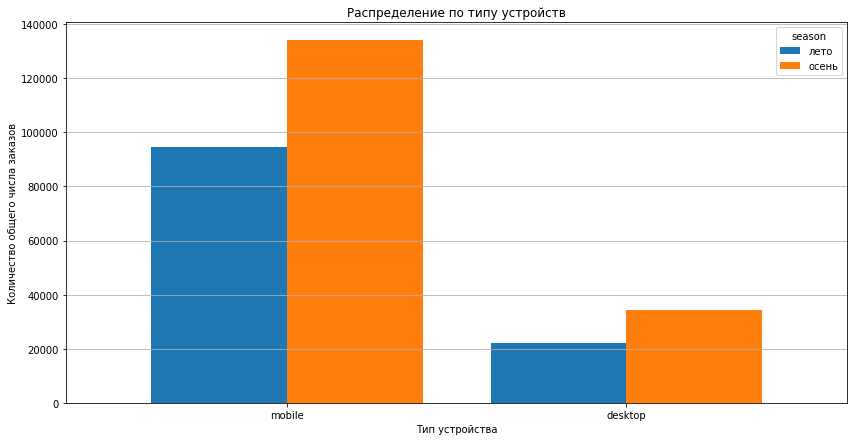

In [53]:
# Создадим таблицу для визуализации распределения заказов по типу устройства
season_device_type = merged_df.pivot_table(
    index='device_type_canonical',
    columns='season',
    values='order_id',
    aggfunc='count',
    fill_value=0
)[['лето', 'осень']].sort_values('осень', ascending=False)

ax = season_device_type.plot(kind='bar', width=0.8, figsize=(14, 7))
plt.title('Распределение по типу устройств')
plt.xlabel('Тип устройства')
plt.ylabel('Количество общего числа заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')

Изучите изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

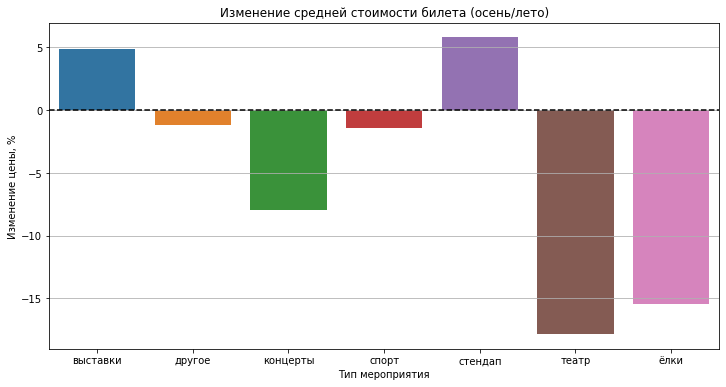

In [54]:
# Расчет средней стоимости билета по сезонам
summer_mean_prices = merged_df[merged_df['season'] == 'лето'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()
autumn_mean_prices = merged_df[merged_df['season'] == 'осень'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()

# Рассчитаем долю изменения цены
price_change = ((autumn_mean_prices - summer_mean_prices) / summer_mean_prices * 100).reset_index()
price_change.columns = ['event_type', 'price_change_percent']

plt.figure(figsize=(12, 6))
sns.barplot(data=price_change, x='event_type', y='price_change_percent')
plt.axhline(0, color='black', linestyle='--')
plt.title('Изменение средней стоимости билета (осень/лето)')
plt.ylabel('Изменение цены, %')
plt.xlabel('Тип мероприятия')
plt.xticks(rotation=0)
plt.grid(axis='y')

#### Промежуточные выводы
- На графике видно увеличение количества заказов с июня по ноябрь
- Пик активности приходится на октябрь
- Самый популярный тип мероприятия это концерты
- Практически нет сезонных изменений у типов мероприятий : стендап, выставки, другое
- Самый популярный возросной рейтиг событий - 16
- На возростной рейтинг 18, практически не влияет сезонность
- Осенью билеты подешевели на 5 категорий из 7. Сильнее всего подешевели билеты на театр и елки. Подорожали билеты на выставки и стендап (категории мало зависимы от сезонности).

### Анализ активности пользователей

Изучим активность пользователей осенью 2024 года. В наешм распоряжении данные за два осенних месяца.

In [55]:
# Фильтрация осенних данных
autumn_df = merged_df[merged_df['month'].isin([9, 10])]

# Сводная таблица по дням
daily_stats = autumn_df.groupby(autumn_df['created_dt_msk']).agg(
    total_orders=('order_id', 'count'),          # Общее число заказов
    dau=('user_id', 'nunique'),                  # DAU (уникальные пользователи)
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')  # Средняя стоимость билета
).reset_index()

In [56]:
# Добавим клонку со средним значением билетов на пользователя
daily_stats['avg_ticket_on_user'] = daily_stats['total_orders'] / daily_stats['dau']

In [57]:
# Проверим первые 5 строк полученной таблицы
daily_stats.head()

,created_dt_msk,total_orders,dau,avg_ticket_price,avg_ticket_on_user
0,2024-09-01,1327,564,200.168885,2.352837
1,2024-09-02,1366,568,187.745842,2.404930
2,2024-09-03,5099,772,79.503165,6.604922
3,2024-09-04,1761,681,176.474412,2.585903
4,2024-09-05,1916,731,187.771999,2.621067


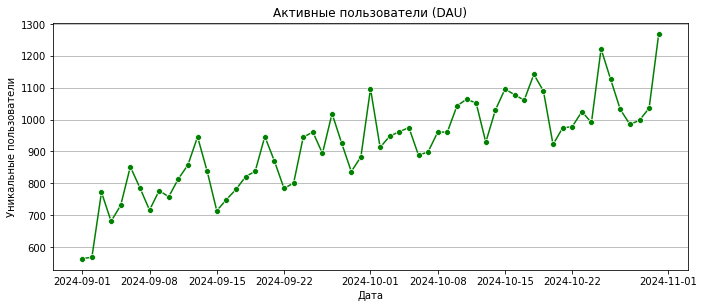

In [58]:
# DAU (уникальные пользователи)
plt.figure(figsize=(25, 10))
plt.subplot(2, 2, 2)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='dau', marker='o', color='green')
plt.title('Активные пользователи (DAU)')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи')
plt.grid(axis='y')

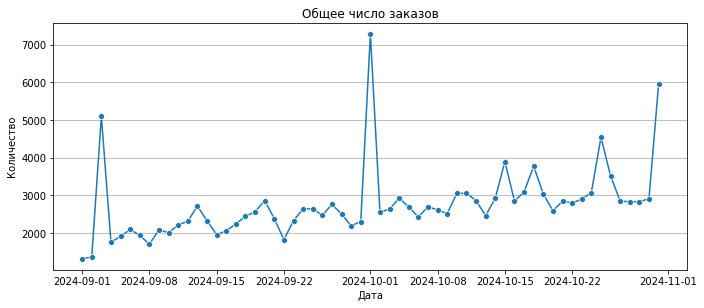

In [59]:
# Общее число заказов
plt.figure(figsize=(25, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='total_orders', marker='o')
plt.title('Общее число заказов')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid(axis='y')

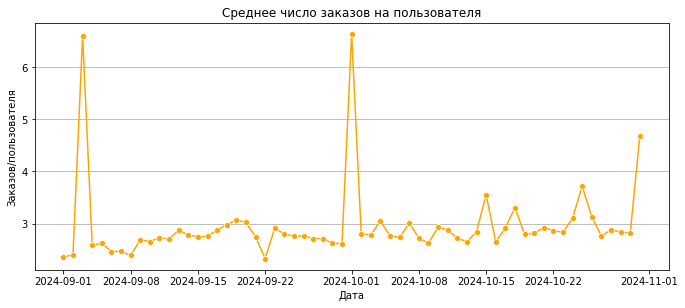

In [60]:
# ГСреднее число заказов на пользователя
plt.figure(figsize=(25, 10))
plt.subplot(2, 2, 3)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='avg_ticket_on_user', marker='o', color='orange')
plt.title('Среднее число заказов на пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователя')
plt.grid(axis='y')

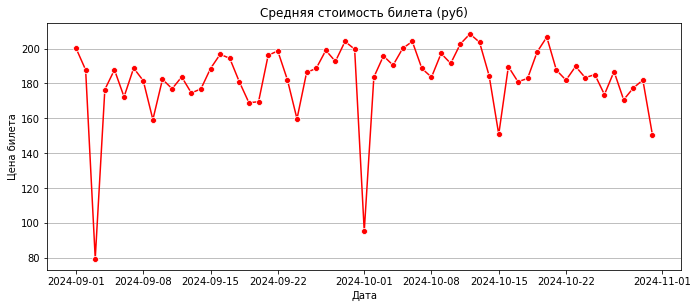

In [61]:
# Средняя стоимость билета
plt.figure(figsize=(25, 10))
plt.subplot(2, 2, 4)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='avg_ticket_price', marker='o', color='red')
plt.title('Средняя стоимость билета (руб)')
plt.xlabel('Дата')
plt.ylabel('Цена билета')
plt.grid(axis='y')

<Figure size 1800x720 with 0 Axes>

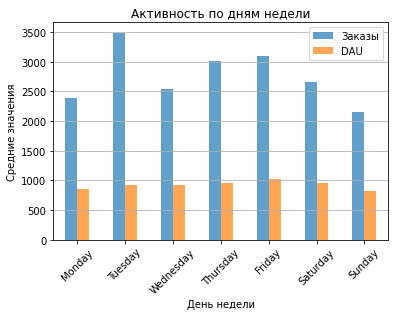

In [62]:
# Добавляем день недели
daily_stats['day_of_week'] = pd.to_datetime(daily_stats['created_dt_msk']).dt.day_name()

# Группировка по дням недели
weekday_stats = daily_stats.groupby('day_of_week').agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'avg_ticket_on_user': 'mean',
    'avg_ticket_price': 'mean'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Визуализация
plt.figure(figsize=(25, 10))
weekday_stats[['total_orders', 'dau']].plot(kind='bar', alpha=0.7)
plt.title('Активность по дням недели')
plt.ylabel('Средние значения')
plt.xlabel('День недели')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(['Заказы', 'DAU'])

#### Промежуточные выводы
- Наблюадается стабильный рост активных пользователей
- Есть корреляция между стоимости билетов и количеством билетов. На графике видно несколько несколько точек, где цена сильно снижается, в эти же даты, можно увидеть вссплеск числа заказов.

### Анализ мероприятий по регионам

Для каждого региона посчитайте уникальное количество мероприятий и общее число заказов.

In [63]:
# Группировка по регионам
region_stats = autumn_df.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),  # Уникальные мероприятия
    total_orders=('order_id', 'count'),     # Всего заказов
    total_revenue=('revenue_rub', 'sum')    # Суммарная выручка
).sort_values('total_orders', ascending=False).reset_index()

# Добавляем доли
region_stats['events_share'] = (region_stats['unique_events'] / region_stats['unique_events'].sum()) * 100
region_stats['orders_share'] = (region_stats['total_orders'] / region_stats['total_orders'].sum()) * 100

In [64]:
region_stats.head()

,region_name,unique_events,total_orders,total_revenue,events_share,orders_share
0,Каменевский регион,3910,46663,2.859092e+07,24.642339,27.751478
1,Североярская область,2610,20655,1.046188e+07,16.449234,12.283968
2,Медовская область,369,12040,2.341838e+06,2.325581,7.160444
3,Широковская область,803,8715,4.227784e+06,5.060818,5.182996
4,Озернинский край,296,7478,6.632334e+06,1.865507,4.447326


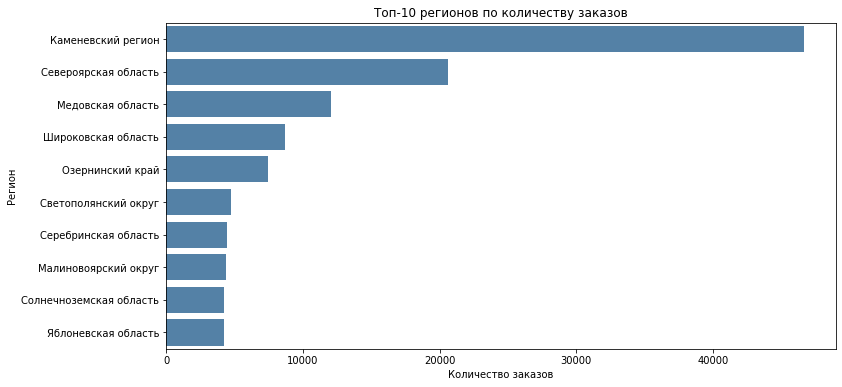

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(data=region_stats.head(10), 
            y='region_name', 
            x='total_orders', 
            orient='h', 
            color='steelblue')
plt.title('Топ-10 регионов по количеству заказов')
plt.ylabel('Регион')
plt.xlabel('Количество заказов')
plt.show()

Text(0.5, 0, 'Количество мероприятий')

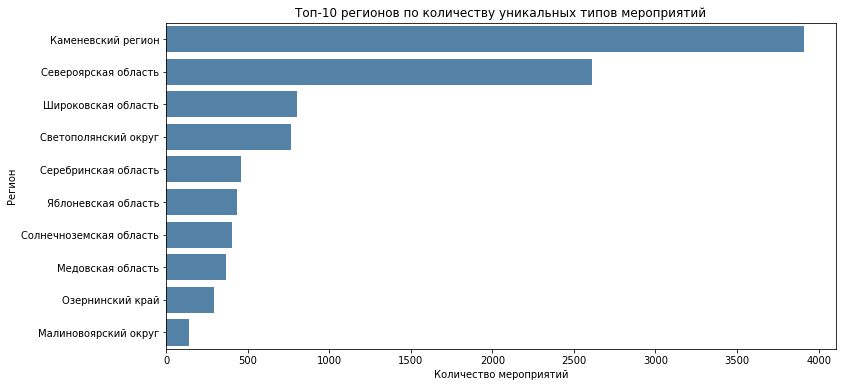

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(data=region_stats.head(10).sort_values('unique_events', ascending=False),
            y='region_name',
            x='unique_events',
            orient='h',
            color='steelblue')
plt.title('Топ-10 регионов по количеству уникальных типов мероприятий')
plt.ylabel('Регион')
plt.xlabel('Количество мероприятий')

#### Промежуточные выводы
Заказов в Каменевском регионе в разы больше, чем в любом другом, возможно этот ркгион самый большой и густонаселенный из всех из всех, возможно в остальных регионах недостаточно рекламы мероприятий.

### Анализ партнеров сервиса

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. 

In [67]:
# Группировка по партнёрам
partner_stats = autumn_df.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),  # Уникальные мероприятия
    total_orders=('order_id', 'count'),      # Всего заказов
    total_revenue=('revenue_rub', 'sum')     # Суммарная выручка
).sort_values('total_revenue', ascending=False).reset_index()

# Добавляем доли
partner_stats['revenue_share'] = (partner_stats['total_revenue'] / partner_stats['total_revenue'].sum()) * 100

In [68]:
partner_stats.head()

,service_name,unique_events,total_orders,total_revenue,revenue_share
0,Билеты без проблем,2843,32127,11817851.65,14.538409
1,Мой билет,1001,19260,10675904.41,13.133577
2,Облачко,1409,15478,10611051.69,13.053794
3,Лови билет!,3616,25788,10375964.65,12.764589
4,Весь в билетах,599,9405,9324685.93,11.471298


In [69]:
# Проверим сколько у нас всего партнеров
unique_services_count = partner_stats['service_name'].nunique()
print(f"Количество партнеров: {unique_services_count}")

Количество партнеров: 35


Text(0.5, 0, 'Количество выручки')

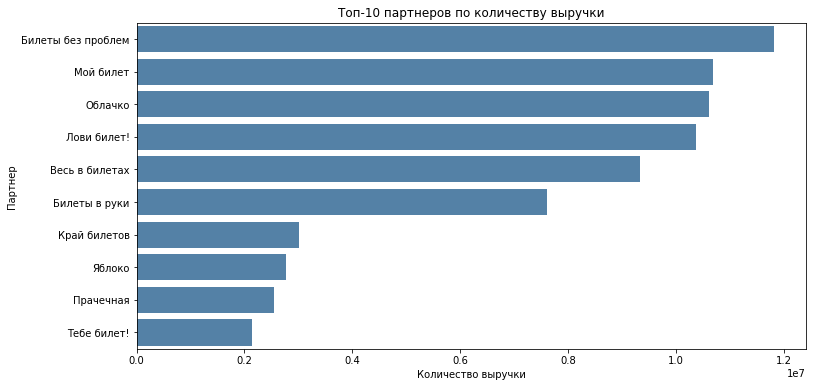

In [70]:
plt.figure(figsize=(12, 6))
sns.barplot(data=partner_stats.head(10).sort_values('total_revenue', ascending=False),
            y='service_name',
            x='total_revenue',
            orient='h',
            color='steelblue')
plt.title('Топ-10 партнеров по количеству выручки')
plt.ylabel('Партнер')
plt.xlabel('Количество выручки')

Text(0.5, 0, 'Количество мероприятий')

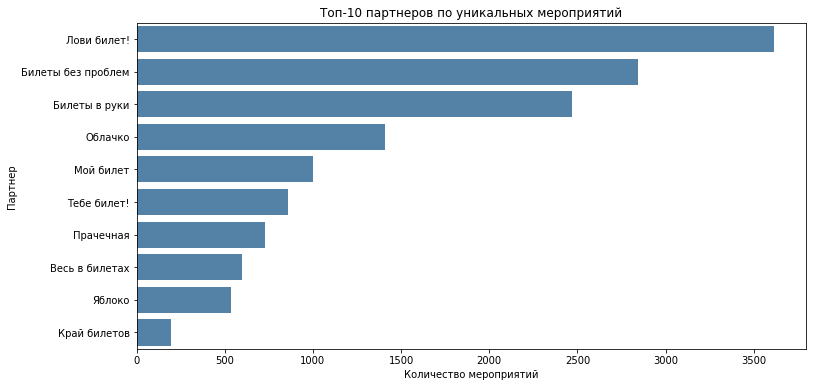

In [71]:
plt.figure(figsize=(12, 6))
sns.barplot(data=partner_stats.head(10).sort_values('unique_events', ascending=False),
            y='service_name',
            x='unique_events',
            orient='h',
            color='steelblue')
plt.title('Топ-10 партнеров по уникальных мероприятий')
plt.ylabel('Партнер')
plt.xlabel('Количество мероприятий')

Text(0.5, 0, 'Количество заказов')

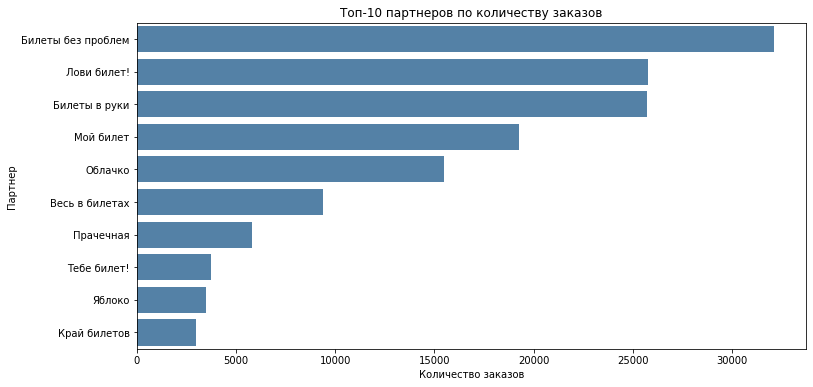

In [72]:
plt.figure(figsize=(12, 6))
sns.barplot(data=partner_stats.head(10).sort_values('total_orders', ascending=False),
            y='service_name',
            x='total_orders',
            orient='h',
            color='steelblue')
plt.title('Топ-10 партнеров по количеству заказов')
plt.ylabel('Партнер')
plt.xlabel('Количество заказов')

#### Промежуточные выводы
- Каменевский регион явный лидер по количеству заказов.
- По количеству уникальных мероприятий  в лидерах Каменевский регион и Североярская область.
- Среди партнеров явного приемущества не наблюдается, однако "Билеты без проблем" явлиются лидирующим партнером по количеству заказов и выручки.

### Проверка гипотез

Необходимо проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [73]:
# Разделяем на группы по типу устройств
mobile_users = merged_df[merged_df['device_type_canonical'] == 'mobile']
desktop_users = merged_df[merged_df['device_type_canonical'] == 'desktop']

#### Гипотеза 1: 
Среднее количество заказов на одного пользователя
- H0: Среднее количество заказов мобильных и десктопных пользователей одинаково
- H1: Среднее количество заказов мобильных пользователей выше

In [74]:
# Рассчитываем метрику
mobile_orders = mobile_users.groupby('user_id')['order_id'].count()
desktop_orders = desktop_users.groupby('user_id')['order_id'].count()

In [75]:
# Тест на нормальность
print("Тест Шапиро-Уилка для мобильных пользователей:")
print(stats.shapiro(mobile_orders))
print("Тест Шапиро-Уилка для десктопных пользователей:")
print(stats.shapiro(desktop_orders))

Тест Шапиро-Уилка для мобильных пользователей:
ShapiroResult(statistic=0.06106281280517578, pvalue=0.0)
Тест Шапиро-Уилка для десктопных пользователей:
ShapiroResult(statistic=0.10096067190170288, pvalue=0.0)


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результаты теста Шапиро-Уилка с p-value=0.0 для обеих групп однозначно указывают, что распределения существенно отклоняются от нормального

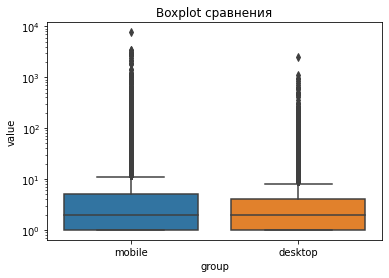

In [76]:
# Boxplot
combined = pd.concat([pd.DataFrame({'value': mobile_orders, 'group': 'mobile'}),
                      pd.DataFrame({'value': desktop_orders, 'group': 'desktop'})])
sns.boxplot(x='group', y='value', data=combined)
plt.title('Boxplot сравнения')
plt.yscale('log')

Показатель количества заказов на пользователя не имеет нормального распределения и имеет выбросы

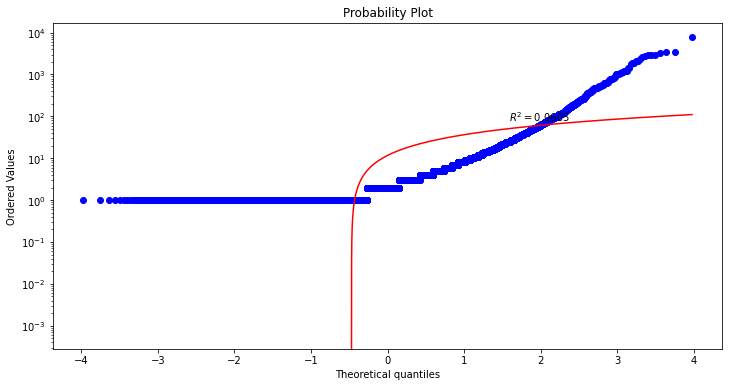

In [77]:
# Q-Q график для mobile
plt.figure(figsize=(12, 6))
stats.probplot(mobile_orders, dist="norm", plot=plt, rvalue=True)
plt.gca().set_yscale('log')

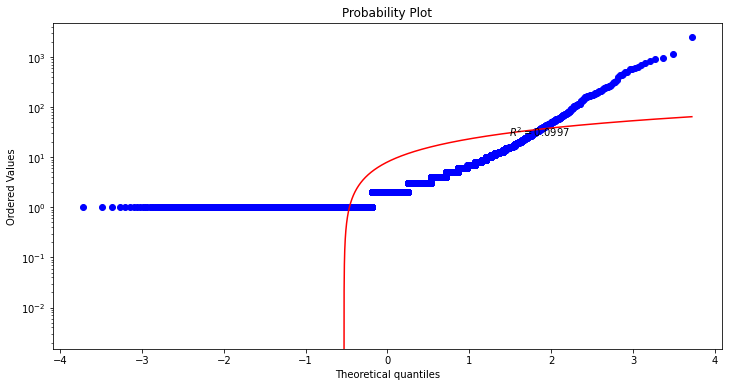

In [78]:
# Q-Q грфик для desktop
plt.figure(figsize=(12, 6))
stats.probplot(desktop_orders, dist="norm", plot=plt, rvalue=True)
plt.gca().set_yscale('log')

Поскольку распределения не нормальные, следует использовать U-тест Манна-Уитни вместо t-теста.

In [79]:
u_stat, p_value = stats.mannwhitneyu(mobile_orders, 
                                   desktop_orders,
                                   alternative='greater')
print(f"U-тест Манна-Уитни: U={u_stat:.1f}, p={p_value:.4f}")

U-тест Манна-Уитни: U=71549897.0, p=0.0000


In [80]:
alpha = 0.05
if p_value < alpha:
    print(f"\nПри alpha = {alpha} отвергаем H0: среднее количество заказов мобильных пользователей выше\
\nСреднее количество заказов:\
\n - mobile = {mobile_orders.mean():.2f}\
\n - desktop = {desktop_orders.mean():.2f}")
else:
    print(f"\nПри alpha = {alpha} не отвергаем H0: нет доказательств, что среднее количество заказов различается\
\n Среднее количество заказов:\
\n - mobile = {mobile_orders.mean():.2f}\
\n - desktop = {desktop_orders.mean():.2f}")


При alpha = 0.05 отвергаем H0: среднее количество заказов мобильных пользователей выше
Среднее количество заказов:
 - mobile = 11.70
 - desktop = 8.07


#### Гипотеза 2: 
Среднее время между заказами пользователей
- H0: Среднее время между заказами у мобильных и десктопных пользователей одинаково
- H1: Среднее время между заказами у мобильных пользователей больше

In [81]:
# Подготовка данных для пользователей mobile
mobile_time_between = (
    mobile_users.sort_values(['user_id', 'created_dt_msk'])
    .groupby('user_id')['created_dt_msk']
    .apply(lambda x: x.diff().dt.days.mean())
    .dropna()
)

In [82]:
# Подготовка данных для пользователей desktop
desktop_time_between = (
    desktop_users.sort_values(['user_id', 'created_dt_msk'])
    .groupby('user_id')['created_dt_msk']
    .apply(lambda x: x.diff().dt.days.mean())
    .dropna()
)

In [83]:
# Тест на нормальность
print("Тест Шапиро-Уилка для мобильных пользователей:")
print(stats.shapiro(mobile_time_between))
print("Тест Шапиро-Уилка для десктопных пользователей:")
print(stats.shapiro(desktop_time_between))

Тест Шапиро-Уилка для мобильных пользователей:
ShapiroResult(statistic=0.7074581384658813, pvalue=0.0)
Тест Шапиро-Уилка для десктопных пользователей:
ShapiroResult(statistic=0.6904916763305664, pvalue=0.0)


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результаты теста Шапиро-Уилка с p-value=0.0 для обеих групп однозначно указывают, что распределения существенно отклоняются от нормального

<AxesSubplot:xlabel='group', ylabel='value'>

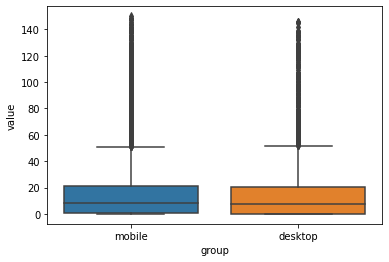

In [84]:
combined = pd.concat([pd.DataFrame({'value': mobile_time_between, 'group': 'mobile'}),
                      pd.DataFrame({'value': desktop_time_between, 'group': 'desktop'})])
sns.boxplot(x='group', y='value', data=combined)

Показатель среднего времени между заказами не имеет нормального распределения и имеет выбросы.
Поскольку распределения не нормальные, следует использовать U-тест Манна-Уитни вместо t-теста.

In [85]:
u_stat, p_value = stats.mannwhitneyu(mobile_time_between, 
                                   desktop_time_between,
                                   alternative='greater')
print(f"U-тест Манна-Уитни: U={u_stat:.1f}, p={p_value:.4f}")

U-тест Манна-Уитни: U=24790952.0, p=0.0000


In [86]:
alpha = 0.05
if p_value < alpha:
    print(f"При alpha = {alpha} отвергаем H0: среднее время между заказами у мобильных пользователей больше.\
\nМедианное время между заказами:\
\n - Мобильные пользователи: {np.median(mobile_time_between):.1f} дней\
\n - Десктопные пользователи: {np.median(desktop_time_between):.1f} дней \
\n - Разница: {np.median(mobile_time_between) - np.median(desktop_time_between):.1f} дней")
else:
    print(f"При alpha = {alpha} не отвергаем H0: нет доказательств различий во времени между заказами\
\nМедианное время между заказами:\
\n - Мобильные пользователи: {np.median(mobile_time_between):.1f} дней\
\n - Десктопные пользователи: {np.median(desktop_time_between):.1f} дней")

При alpha = 0.05 отвергаем H0: среднее время между заказами у мобильных пользователей больше.
Медианное время между заказами:
 - Мобильные пользователи: 8.2 дней
 - Десктопные пользователи: 7.5 дней 
 - Разница: 0.8 дней


## Общие выводы и рекомендации

### Сезонная активность и категории мероприятий
- Подтверждено: Осенний рост активности пользователей характерен для большинства категорий, кроме:

- Стендап и выставки — остались на прежнем уровне популярности, но при этом подорожали.

Рекомендации:

- Исследовать причины низкого спроса (недостаток рекламы, слабая вовлеченность партнеров).

- Разработать спецпредложения или маркетинговые кампании для этих категорий.

- Проанализировать ценовую политику — возможно, рост цен снизил спрос.

### Мобильные пользователи
- Подтверждено: Большинство заказов совершается с мобильных устройств.

- Опровергнуто: Время между заказами у мобильных и десктопных пользователей не отличается.

Рекомендации:

- Улучшить UX мобильного приложения (например, упростить повторные заказы).

- Внедрить push-уведомления о новых мероприятиях для мобильной аудитории.

### Региональные различия
Каменевский регион лидирует по заказам и выручке, остальные — значительно отстают.

Возможные причины:

- Высокая плотность населения.

- Лучшая работа партнеров/площадок.

- Недостаток рекламы в других регионах.

Рекомендации:

- Изучить аудиторию в отстающих регионах (предпочтения, платежеспособность).

- Усилить продвижение в регионах с потенциалом (например, через локальных инфлюенсеров).

### Партнеры сервиса
Среди 35 партнеров 6 лидеров генерируют основную выручку.

Рекомендации:

- Разработать индивидуальные условия для топ-партнеров (бонусы за объем).

- Стимулировать остальных партнеров:

- Обучение продвижению мероприятий.

- Анализ успешных кейсов лидеров.